In [1]:
from briertools.scorers import DCAScorer, LogLossScorer, BrierScorer
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
log_loss_scorer = LogLossScorer()
dca_scorer = DCAScorer()

In [3]:
def simulate_binormal(loc, scale=1, scale_neg=1, loc_neg=None, n=3000, fix=True):
    if loc_neg is None:
        loc_neg = -loc
    neg = np.random.normal(loc=loc_neg, scale=scale_neg, size=n)
    pos = np.random.normal(loc=loc, scale=scale, size=n)
    if fix:
        pos, neg = neg, pos
    y_pred = scipy.special.expit(np.concatenate([pos, neg]))
    y_true = np.concatenate([pos * 0 + 1, neg * 0])
    
    return y_pred, y_true

from matplotlib.scale import FuncScale

def scale_x_one_minus_one_minus_x_2(ax):
    def forward(x):
        return 1 - (1 - x)**2  # This is the actual transformation for labels
    def inverse(y):
        one_minus = 1 - y
        return 1 - np.sign(one_minus) * np.sqrt(np.abs(one_minus))
    ax.set_xscale(FuncScale(ax.xaxis, (forward, inverse)))
    ax.set_title("1-(1-x)^2")

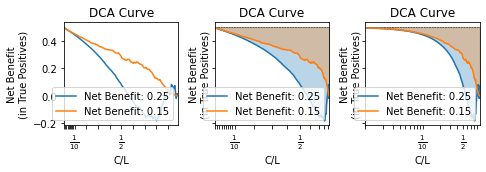

In [4]:
y_hat_0, y_0 = simulate_binormal(.8, 1, fix=False, n=300)
y_hat_1, y_1 = simulate_binormal(3, .5, loc_neg=1, fix=False, n=300)
fig, axs = plt.subplots(1, 3, figsize=(7, 2.5), sharey=True)
axs[2].set_xscale('log')
scale_x_one_minus_one_minus_x_2(axs[1])

for ax in axs:
    plt.sca(ax)
    dca_scorer.plot_curve(y_1, y_hat_1, ticks=[1./101, 1./2], threshold_range=[1e-2,1-1e-2], fill_range = 0.15 if ax != axs[0] else None)
    dca_scorer.plot_curve(y_0, y_hat_0, ticks=[1./101, 1./2], threshold_range=[1e-2,1-1e-2], fill_range = 0.4 if ax != axs[0] else None)
    if ax != axs[0]:
        plt.axhline(y=0.5, color="black", linestyle="--", lw=0.5, zorder=-10)
    plt.xlim([1e-2, 1-1e-2])
    plt.xticks([.1, .25, .5, .75], r"$\frac{1}{10}$ $\frac{1}{4}$ $\frac{1}{2}$ $\frac{3}{4}$".split())
    plt.xticks([.01, .02, .03,.04,.05,.06,.07,.08,.09,.1, .2, .3, .4, .5, .6, .7, .8, .9])
    plt.ylabel("Net Benefit\n(in True Positives)")

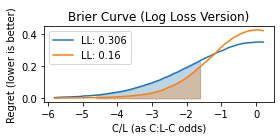

In [5]:
plt.figure(figsize=(4,2))
y_pred, y_true = simulate_binormal(1, 2, scale_neg=2)
log_loss_scorer.plot_curve(y_true, y_pred, threshold_range=(0.003, 0.55), fill_range=(1./101, 1./6), ticks=[1./101, 1./6, 1./2])

y_pred, y_true = simulate_binormal(1, 1)
log_loss_scorer.plot_curve(y_true, y_pred, threshold_range=(0.003, 0.55), fill_range=(1./101, 1./6), ticks=[1./101, 1./6, 1./2])

In [6]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf = clf.fit(y_true, y_pred)
dca_scorer.scorer(clf, y_true, y_pred)

0.3022935691123291

In [8]:
dca_scorer._get_regret(y_true, y_pred, np.linspace(0.2, 0.5, 100))

array([0.23933333, 0.24216515, 0.24666869, 0.24883333, 0.25227273,
       0.25539545, 0.25920909, 0.26253333, 0.26681212, 0.27063636,
       0.27531717, 0.27783333, 0.28166667, 0.28516919, 0.28847475,
       0.29155152, 0.29573333, 0.29867828, 0.30205758, 0.30636364,
       0.3101899 , 0.31357879, 0.31641111, 0.31893485, 0.322     ,
       0.32516061, 0.32838788, 0.33111212, 0.33341111, 0.33687879,
       0.33960909, 0.34189545, 0.34364646, 0.34621667, 0.3490303 ,
       0.35074343, 0.35324545, 0.3549101 , 0.35679798, 0.35985606,
       0.36220101, 0.36402222, 0.36599394, 0.36856263, 0.37088889,
       0.37374394, 0.37568586, 0.37755556, 0.37912424, 0.38035354,
       0.3814101 , 0.38332576, 0.38496263, 0.38607273, 0.38706061,
       0.38863889, 0.39062121, 0.39185152, 0.39350505, 0.39536616,
       0.39657879, 0.39807626, 0.39997879, 0.40098182, 0.40173737,
       0.4030798 , 0.40463333, 0.40592929, 0.40687475, 0.40770455,
       0.40850808, 0.40988788, 0.4108303 , 0.41159848, 0.41223

In [ ]:
threshold_range = (0.2, 0.5)
y_near = np.array(threshold_range)[np.array(y_true, dtype=int)]
y_far = np.array(threshold_range)[1 - np.array(y_true, dtype=int)]

loss_near = dca_scorer._pointwise_l1_loss(y_true, y_near)
loss_far = dca_scorer._pointwise_l1_loss(y_true, y_far)
loss_pred = dca_scorer._pointwise_l1_loss(y_true, y_pred)
assert np.all(loss_near <= loss_far)

loss_clip = np.clip(loss_pred, loss_near, loss_far)

In [ ]:
y_near